In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib.ticker import LogLocator, FormatStrFormatter
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

## importance sampling during training

Below is an example implementation of a PINN in PyTorch that incorporates self-adaptive importance sampling similar to the paper. In this simplified example, we solve a one-dimensional PDE (here, we use a toy example u_xx +sin(πx)=0) by training on collocation points that are periodically updated by sampling more densely in regions where the PDE residual is high.

You can adjust the PDE, network architecture, and hyperparameters as needed.

### Sampling Strategy:

Initially, collocation points are sampled uniformly.
In the function importance_sampling, the model is evaluated on a dense grid over the domain. The absolute value of the residual (plus a small epsilon) forms a weight distribution, and new collocation points are drawn according to this distribution. This mimics the failure-informed sampling by focusing training on regions where the PDE is not well satisfied.
### Training Loop:
The model trains for a set number of epochs. Every few epochs (here, every 1000 epochs), the collocation points are updated using the importance sampling procedure.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network for the PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        # Create a fully connected network based on the provided layers list.
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = self.activation(layer(a))
        output = self.layers[-1](a)
        return output

# Define the PDE residual
def pde_residual(model, x):
    # Enable gradient tracking on x
    x.requires_grad = True
    u = model(x)
    # Compute first derivative u_x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Compute second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    # For this example, our PDE is: u_xx + sin(pi*x) = 0
    residual = u_xx + torch.sin(np.pi * x)
    return residual

# Generate initial collocation points uniformly in the domain [lb, ub]
def generate_collocation_points(n_points, lb, ub):
    x = np.random.uniform(lb, ub, (n_points, 1))
    return torch.tensor(x, dtype=torch.float32)

# Importance sampling: Evaluate the residual on a fine grid and sample new points
def importance_sampling(model, n_points, lb, ub):
    # Create a fine grid over the domain
    x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
    x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
    
    # Evaluate the residual on the fine grid
    residual = pde_residual(model, x_fine_tensor)
    res_val = residual.detach().abs().squeeze().numpy()  # absolute error
    # Avoid zero probabilities by adding a small epsilon
    eps = 1e-6
    weights = res_val + eps
    weights = weights / np.sum(weights)
    # Sample indices based on the residual weights
    indices = np.random.choice(len(x_fine), size=n_points, replace=True, p=weights)
    sampled_points = x_fine[indices]
    return torch.tensor(sampled_points, dtype=torch.float32)

# Hyperparameters and domain setup
lb, ub = 0.0, 1.0         # Domain boundaries
n_initial = 100           # Number of initial collocation points
n_epochs = 1000           # Total training epochs
sampling_interval = 200  # How often (in epochs) to update the collocation points
learning_rate = 1e-3      # Learning rate

# Define the network architecture (input, hidden layers, output)
layers = [1, 50, 50, 1]
model = PINN(layers)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# Generate the initial set of collocation points
collocation_points = generate_collocation_points(n_initial, lb, ub)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Compute the residual of the PDE at the collocation points
    residual = pde_residual(model, collocation_points)
    loss_res = mse_loss(residual, torch.zeros_like(residual))
    
    # (Optional) Include boundary conditions loss here.
    # For example, enforcing u(0)=0 and u(1)=0:
    x_bc = torch.tensor([[lb], [ub]], dtype=torch.float32)
    u_bc = model(x_bc)
    loss_bc = mse_loss(u_bc, torch.zeros_like(u_bc))
    
    loss = loss_res + loss_bc
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")
    
    # Every sampling_interval epochs, perform importance sampling to update collocation points.
    if (epoch + 1) % sampling_interval == 0:
        collocation_points = importance_sampling(model, n_initial, lb, ub)
        print(f"Resampled collocation points at epoch {epoch+1}")

# After training, evaluate the model on a fine grid and plot the results.
x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
model.eval()
with torch.no_grad():
    u_pred = model(x_fine_tensor).detach().cpu().numpy()

# Exact solution: u(x) = (1/pi^2)*sin(pi*x) with u(0)=u(1)=0.
u_exact = (1/np.pi**2) * np.sin(np.pi * x_fine)

plt.figure(figsize=(8, 5))
plt.plot(x_fine, u_pred, label='PINN Approximation', linewidth=2)
plt.plot(x_fine, u_exact, 'r--', label='Exact Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('PINN Approximation vs Exact Solution')
plt.show()


## Deep reasearch chatGPT

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd

# Define PINN architecture: input (t, params) -> output u
class PINN(nn.Module):
    def __init__(self, param_dim, hidden_dim=50, layers=4):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        input_dim = 1 + param_dim  # time + parameters
        # Build a simple feedforward network
        self.net.add_module('input_layer', nn.Linear(input_dim, hidden_dim))
        self.net.add_module('input_act', nn.Tanh())
        for i in range(layers-1):
            self.net.add_module(f'h{i}_layer', nn.Linear(hidden_dim, hidden_dim))
            self.net.add_module(f'h{i}_act', nn.Tanh())
        self.net.add_module('output_layer', nn.Linear(hidden_dim, 1))
    def forward(self, t, params):
        # t: tensor of shape [N, 1], params: tensor of shape [N, param_dim]
        inp = torch.cat([t, params], dim=1)
        return self.net(inp)

# Initialize model, optimizer
param_dim = 5  # e.g., (m, c, k, u0, v0)
model = PINN(param_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Sample initial collocation points
N_collocation = 10000
# Randomly sample parameter values from prior (assuming normal or uniform for example)
params_samples = sample_parameter_distribution(N_collocation, param_dim)  # user-defined
# Randomly sample times in [0, T]
t_samples = torch.rand(N_collocation, 1) * T_max

# Prepare initial condition values corresponding to params_samples (u0 and v0 are part of params)
# We assume params_samples includes u0 and v0 as components.

# Training loop (simplified)
for epoch in range(initial_epochs):
    optimizer.zero_grad()
    # Pick a batch of collocation points (for simplicity, use all here)
    t_batch = t_samples
    x_batch = params_samples
    # Forward pass
    u_pred = model(t_batch, x_batch)            # predicted u(t)
    # Compute time derivatives for physics residual using autograd
    u_pred_t = autograd.grad(u_pred, t_batch, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_tt = autograd.grad(u_pred_t, t_batch, grad_outputs=torch.ones_like(u_pred_t), create_graph=True)[0]
    # Compute physics residual for harmonic oscillator: m*u_tt + c*u_t + k*u = 0
    m = x_batch[:,0:1]; c = x_batch[:,1:2]; k = x_batch[:,2:3]   # assuming param ordering [m,c,k,u0,v0]
    physics_residual = m*u_pred_tt + c*u_pred_t + k*u_pred
    L_phys = torch.mean(physics_residual**2)
    # Initial condition loss for this batch (for t=0, enforce u = u0 and u_t = v0)
    # Need to filter those points where t is 0 (we can include explicit t=0 points in training set)
    # For simplicity, we'll separately enforce initial conditions:
    u0 = x_batch[:,3:4]; v0 = x_batch[:,4:5]  # initial disp and velocity from params
    # Mask for t=0 points:
    mask = (t_batch == 0).squeeze()
    L_ic = torch.tensor(0.0)
    if mask.any():
        u_pred0 = u_pred[mask]
        u_pred0_t = u_pred_t[mask]
        L_ic = torch.mean((u_pred0 - u0[mask])**2 + (u_pred0_t - v0[mask])**2)
    # Total loss
    loss = L_phys + L_ic
    loss.backward()
    optimizer.step()


## BC trick

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1) Define a small MLP
# -----------------------
class MLP(nn.Module):
    def __init__(self, layers):
        """
        layers: list of integers, e.g. [1, 32, 32, 1]
                meaning 1 input, two hidden layers of size 32, and 1 output.
        """
        super(MLP, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the MLP.
        x: tensor of shape (N, 1) for 1D input.
        """
        # Pass through all but the last layer with activation
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        # Last layer (linear only)
        x = self.linears[-1](x)
        return x

# ---------------------------------------------------------
# 2) Define the "physics-based" solution that embeds BCs
# ---------------------------------------------------------
def pinn_solution(model, x):
    """
    Returns the solution that automatically satisfies u(0)=0 and u(1)=0:
        u(x) = x(1-x)*model(x)
    """
    return model(x) #* (x * (1.0 - x))

# -----------------------------------
# 3) Define the PDE residual
# -----------------------------------
def pde_residual(model, x):
    """
    For PDE: u''(x) = -1 on [0,1], with u(0)=0, u(1)=0.
    Residual: R(x) = u''(x) + 1 = 0
    """
    # Enable gradient tracking
    x.requires_grad = True

    # Compute the "physics-based" output that satisfies BC
    u = pinn_solution(model, x)

    # First derivative u_x
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    # Second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE: u''(x) + 1 = 0 => residual = u_xx + 1
    residual = u_xx + 1.0
    return residual

def boundary_loss(model, x):
    """
    Loss for enforcing boundary conditions u(0)=0 and u(1)=0.
    """
    u = pinn_solution(model, x)
    return torch.mean(u**2)

# -------------------------------------------------
# 4) Create training data and train the PINN
# -------------------------------------------------
if __name__ == "__main__":
    # Hyperparameters
    N_collocation = 100      # number of collocation points
    layers = [1, 32, 32, 1]  # MLP architecture
    lr = 1e-3                # learning rate
    epochs = 500          # training epochs

    # Create model
    model = MLP(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Generate random collocation points in [0,1]
    x_coll = np.random.rand(N_collocation, 1)
    x_coll_torch = torch.tensor(x_coll, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute PDE residual at collocation points
        res = pde_residual(model, x_coll_torch)

        # MSE of residual => we want residual ~ 0
        loss = mse_loss(res, torch.zeros_like(res)) + 10*boundary_loss(model, torch.zeros_like(res)) + 10*boundary_loss(model, torch.ones_like(res))
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

    # ---------------------------------------------

    # 5) Evaluate & compare to exact solution
    # ---------------------------------------------
    model.eval()
    x_test = np.linspace(0, 1, 200).reshape(-1, 1)
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    with torch.no_grad():
        u_pred = pinn_solution(model, x_test_torch).numpy()
    print(f"Epoch {epoch}, Loss: {loss.item():.6e}")
    # Exact solution: u_exact(x) = -(x^2)/2 + (x/2)
    u_exact = -0.5 * x_test**2 + 0.5 * x_test

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(x_test, u_pred, label='PINN Prediction', linewidth=2)
    plt.plot(x_test, u_exact, 'r--', label='Exact Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Poisson with Embedded BCs')
    plt.legend()
    plt.show()

    #error from exact solution
    error = np.abs(u_exact - u_pred)
    print(f"Mean absolute error: {np.mean(error):.6e}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1) Define a small MLP
# -----------------------
class MLP(nn.Module):
    def __init__(self, layers):
        """
        layers: list of integers, e.g. [1, 32, 32, 1]
                meaning 1 input, two hidden layers of size 32, and 1 output.
        """
        super(MLP, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the MLP.
        x: tensor of shape (N, 1) for 1D input.
        """
        # Pass through all but the last layer with activation
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        # Last layer (linear only)
        x = self.linears[-1](x)
        return x

# ---------------------------------------------------------
# 2) Define the "physics-based" solution that embeds BCs
# ---------------------------------------------------------
def pinn_solution(model, x):
    """
    Returns the solution that automatically satisfies u(0)=0 and u(1)=0:
        u(x) = x(1-x)*model(x)
    """
    return model(x) * (x * (1.0 - x))

# -----------------------------------
# 3) Define the PDE residual
# -----------------------------------
def pde_residual(model, x):
    """
    For PDE: u''(x) = -1 on [0,1], with u(0)=0, u(1)=0.
    Residual: R(x) = u''(x) + 1 = 0
    """
    # Enable gradient tracking
    x.requires_grad = True

    # Compute the "physics-based" output that satisfies BC
    u = pinn_solution(model, x)

    # First derivative u_x
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    # Second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE: u''(x) + 1 = 0 => residual = u_xx + 1
    residual = u_xx + 1.0
    return residual

# -------------------------------------------------
# 4) Create training data and train the PINN
# -------------------------------------------------
if __name__ == "__main__":
    # Hyperparameters
    N_collocation = 100      # number of collocation points
    layers = [1, 32, 32, 1]  # MLP architecture
    lr = 1e-3                # learning rate
    epochs = 500          # training epochs

    # Create model
    model = MLP(layers)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Generate random collocation points in [0,1]
    x_coll = np.random.rand(N_collocation, 1)
    x_coll_torch = torch.tensor(x_coll, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute PDE residual at collocation points
        res = pde_residual(model, x_coll_torch)

        # MSE of residual => we want residual ~ 0
        loss = mse_loss(res, torch.zeros_like(res)) #+ boundary_loss(model, torch.zeros_like(res)) + boundary_loss(model, torch.ones_like(res))
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

    # ---------------------------------------------

    # 5) Evaluate & compare to exact solution
    # ---------------------------------------------
    model.eval()
    x_test = np.linspace(0, 1, 200).reshape(-1, 1)
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    with torch.no_grad():
        u_pred = pinn_solution(model, x_test_torch).numpy()
    print(f"Epoch {epoch}, Loss: {loss.item():.6e}")
    # Exact solution: u_exact(x) = -(x^2)/2 + (x/2)
    u_exact = -0.5 * x_test**2 + 0.5 * x_test

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(x_test, u_pred, label='PINN Prediction', linewidth=2)
    plt.plot(x_test, u_exact, 'r--', label='Exact Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Poisson with Embedded BCs')
    plt.legend()
    plt.show()

    #error from exact solution
    error = np.abs(u_exact - u_pred)
    print(f"Mean absolute error: {np.mean(error):.6e}")


### Harmonic oscillator

In [61]:
import numpy as np
import math

def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    """
    Returns y_exact.min() + 1 over the given time array `t`.
    Failure occurs if y_exact.min() < -1  =>  (y_exact.min() + 1) < 0.
    """
    # Check underdamped condition
    if mu**2 >= 4.0 * m * k:
        return None  # This violates underdamped assumption; you can choose how to handle
    
    omega = np.sqrt(k/m - (mu/(2*m))**2)
    
    A = y0
    B = (v0 + (mu/(2*m))*y0) / omega
    
    # y_exact(t)
    y_exact = np.exp(-mu*t/(2*m)) * (A*np.cos(omega*t) + B*np.sin(omega*t))
    
    return y_exact.min() + 1

def normal_pdf(x, mean, std):
    """Compute 1D normal PDF."""
    return 1.0/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2)

# Grid definitions (±3σ around each mean):
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.05
num_points = 500  # Increase if you need a finer grid

m_vals = np.linspace(m_mean +2*m_std, m_mean + 4*m_std, num_points)
mu_vals = np.linspace(mu_mean - 4*mu_std, mu_mean -2*mu_std , num_points)

# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu, k=5.0, y0=-0.4, v0=3.0)
        G[j, i] = np.nan if g_val is None else g_val
        # If None is returned, skip
        if g_val is None:
            continue
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = m
                best_mu = mu
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.4f}\n"
          f"  mu = {best_mu:.4f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3106
  mu = 0.4601
  g  = 0.000997   (should be close to 0)
  Joint PDF = 5.107185e-03


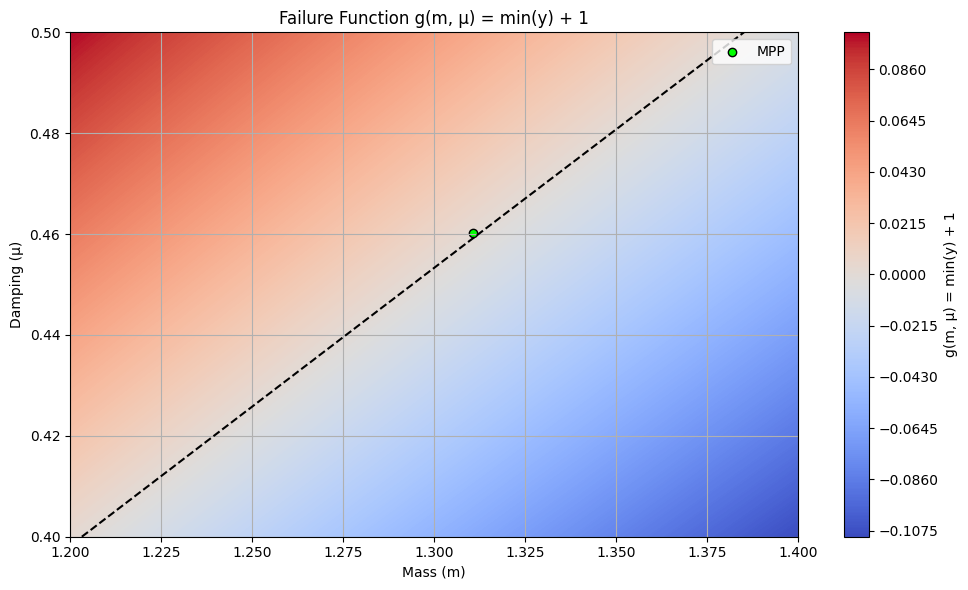

In [63]:
# Create contour plot
M, MU = np.meshgrid(m_vals, mu_vals)
plt.figure(figsize=(10, 6))
contour = plt.contourf(M, MU, G, levels=500, cmap='coolwarm')
plt.colorbar(contour, label='g(m, μ) = min(y) + 1')
plt.contour(M, MU, G, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.scatter(best_m,best_mu, color='lime', edgecolor='black',  label='MPP')
# plt.scatter(m_mean, mu_mean, color='red', edgecolor='black', label='Mean (m, μ)')
plt.xlabel('Mass (m)')
plt.ylabel('Damping (μ)')
plt.title('Failure Function g(m, μ) = min(y) + 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

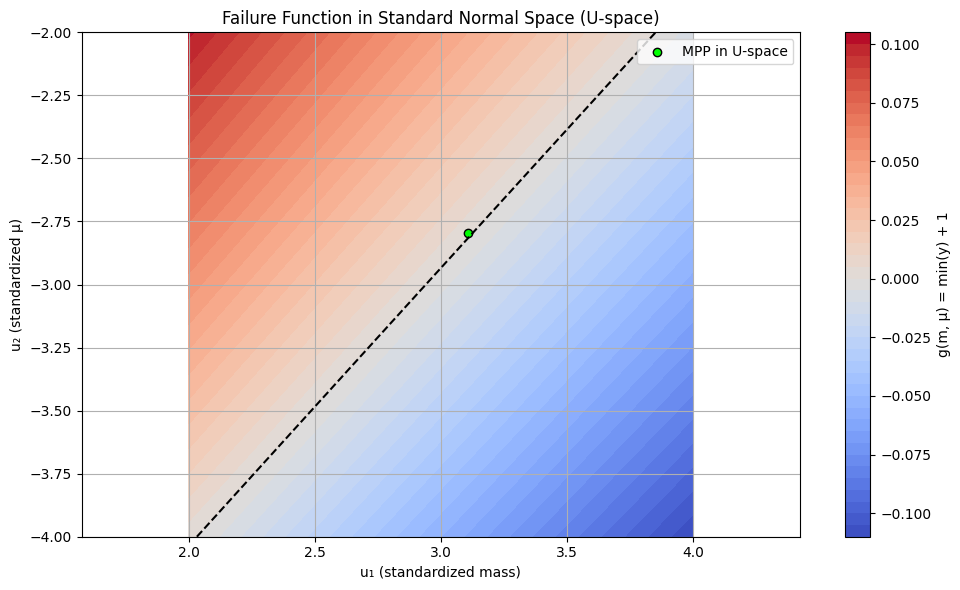

In [65]:
# Constants (from the original problem)
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.05

# Time vector for evaluating the solution
t_grid = np.linspace(0, 5, 1000)

# Define the oscillator function
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    if mu**2 >= 4.0 * m * k:
        return None
    omega = np.sqrt(k/m - (mu/(2*m))**2)
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    return y_exact.min() + 1

# Grid in standard normal space
num_points = 150
u1_vals = np.linspace(2, 4, num_points)
u2_vals = np.linspace(-4, -2, num_points)

U1, U2 = np.meshgrid(u1_vals, u2_vals)
G_std = np.full(U1.shape, np.nan)

# Evaluate g(m, mu) on the standard normal grid
for i in range(len(u2_vals)):
    for j in range(len(u1_vals)):
        m = u1_vals[j] * m_std + m_mean
        mu = u2_vals[i] * mu_std + mu_mean
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu)
        if g_val is not None:
            G_std[i, j] = g_val

# Transform MPP (m=1.335, mu=0.4725) to standard normal space
m_mpp, mu_mpp = best_m, best_mu
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

# Plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(U1, U2, G_std, levels=50, cmap='coolwarm')
plt.colorbar(contour, label='g(m, μ) = min(y) + 1')
plt.contour(U1, U2, G_std, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.scatter(0, 0, color='blue', edgecolor='black', label='Mean (m, μ)')
# # MPP
plt.scatter(u1_mpp, u2_mpp, color='lime', edgecolor='black', label='MPP in U-space')
plt.xlabel('u₁ (standardized mass)')
plt.ylabel('u₂ (standardized μ)')
plt.title('Failure Function in Standard Normal Space (U-space)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
from scipy.optimize import minimize
def MPP_objective(x,model,t, values, lambda_penalty, norm_info):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    all_values = list(x) + values
    pred_params = make_input_params(t, all_values, norm_info)
    lsf = limit_state_function_G(model, t, pred_params, differentiable=False)
    deviation=0
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in ['m', 'mu']:
            deviation+=(abs(x[i] - specs[param]['mean']) / specs[param]['std'])
    penalty = lambda_penalty * deviation

    return (abs(lsf) + penalty).item()
    
def find_MPP(model, t, values, norm_info, lamdba_penalty = 0.001):
    """
    Find the most probable point (MPP) using optimization.
    """
    MPP=[]
    x = []
    other_values = []
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in ['m', 'mu']:
            x.append(values[i])
        else:
            other_values.append(values[i])
    res = minimize(
        MPP_objective, 
        x, 
        args=(model, t, other_values, lamdba_penalty, norm_info), 
        method='Nelder-Mead'
        )
    if res.success:
        MPP.append(res.x)
    else:
        print(f"Optimization did not converge from initial guess {x}")
    return MPP

t_test = np.linspace(0, 5, 100)
MPP_start = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

MPP = find_MPP(mass_mu_model, t_test, MPP_start, params['norm_info'], lamdba_penalty=0.001)
print(f"MPP: {MPP}")

In [ ]:
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans

# === Generate Latin Hypercube samples ===
LHS_samples, sampled_params = generate_latin_hypercube_samples(specs, params['norm_info'], num_samples=10000)

# === Evaluate g(x) and residuals ===
t_tensor = torch.from_numpy(t_test).float().view(-1, 1).requires_grad_(True)
t0_tensor = torch.zeros_like(t_tensor).requires_grad_(True)

G_values = []
residual_values = []

for i in range(len(LHS_samples)):
    row = LHS_samples[i]
    input = make_input_params(t_test, row, params['norm_info'])

    m_tensor = input[0].requires_grad_(True)
    mu_tensor = input[1].requires_grad_(True)
    k_tensor = input[2].requires_grad_(True)
    y0_tensor = input[3].requires_grad_(True)
    v0_tensor = input[4].requires_grad_(True)

    # Limit state function g(x)
    G_value = limit_state_function_G(PINN_model, t_test, input, differentiable=False).item()
    G_values.append(G_value)

    # Residuals
    pde_residual = pde_loss(PINN_model, t_tensor, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
    boundary_residual = boundary_loss(PINN_model, t0_tensor, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
    residual_values.append(pde_residual + boundary_residual)

# === Convert to NumPy arrays for sampling ===
g_vals = np.array(G_values)
residual_vals = np.array(residual_values)

# === Sampling parameters ===
alpha_g = 20
p_residual = 2
n_g = 500
n_residual = 500
k_residual = 100

# === Step 3a: Sample near g(x) ≈ 0 ===
g_weights = np.exp(-alpha_g * np.abs(g_vals))
g_weights /= g_weights.sum()
g_indices = np.random.choice(len(LHS_samples), size=n_g, p=g_weights, replace=False)
g_selected = LHS_samples[g_indices]

# === Step 3b: Sample from residual-based importance ===
res_weights = residual_vals**p_residual
res_weights /= res_weights.sum()
res_indices = np.random.choice(len(LHS_samples), size=n_residual, p=res_weights, replace=False)
res_selected = LHS_samples[res_indices]

# === Step 4: K-means on residual-selected points ===
kmeans = KMeans(n_clusters=k_residual, random_state=42)
kmeans.fit(res_selected)

# Find representative point in each cluster (nearest in res_selected)
tree = cKDTree(res_selected)
_, cluster_indices = tree.query(kmeans.cluster_centers_)
diverse_res_selected = res_selected[cluster_indices]

# === Step 5: Combine all selected points ===
final_collocation_points = np.vstack([g_selected, diverse_res_selected])

# Optional: convert to DataFrame for inspection
import pandas as pd
collocation_df = pd.DataFrame(final_collocation_points, columns=sampled_params)


In [1]:
def z_score_normalize_simple(x, mean, std):
    """Applies Z-score normalization."""
    return (x - mean) / std

In [16]:
N=5

t_coll = torch.rand(N, 1) * 5
params = {'t_coll': t_coll}
specs = {
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 8},
       'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -8, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
    }
# Also prepare a normalization info dictionary if normalization is used.
norm_info = {}
distribute=['m','mu','v0']
normalize=True
# For each parameter, either sample uniformly (if distributed) or use a constant value.
for param in ['m', 'mu', 'k', 'y0', 'v0']:
    spec = specs[param]
    mean = spec['mean']
    std = spec['std']
    lower = mean + spec['lower_multiplier'] * std
    upper = mean + spec['upper_multiplier'] * std
    
    if param in distribute:
        # Sample uniformly for distributed parameters.
        tensor = torch.FloatTensor(N, 1).uniform_(lower, upper)
        if normalize:
            # Apply Z-score normalization
            tensor = z_score_normalize_simple(tensor, mean, std)
            # Store normalization info for later inversion in the loss functions.
            norm_info[param] = {'mean': mean, 'std': std}
        tensor.requires_grad_(False)
    else:
        # Use a constant value for non-distributed parameters.
        tensor = torch.tensor([[mean]], requires_grad=False)
        tensor = tensor.expand(N, -1)
    params[param] = tensor
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)
    params['t0'] = t0

In [17]:
print(params)

{'t_coll': tensor([[3.5157],
        [0.4837],
        [3.6840],
        [1.5689],
        [3.5622]]), 'm': tensor([[ 5.3040],
        [-0.7046],
        [ 2.3101],
        [ 6.9083],
        [ 2.4436]]), 't0': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True), 'mu': tensor([[-0.0325],
        [-0.8611],
        [-4.4317],
        [-0.4512],
        [ 0.0677]]), 'k': tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.]]), 'y0': tensor([[-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000]]), 'v0': tensor([[-1.0286],
        [ 1.5418],
        [-0.6367],
        [ 1.5948],
        [ 2.5294]])}


In [18]:
t_coll = params['t_coll']
m_val  = params['m']
mu_val = params['mu']
k_val  = params['k']
y0_val = params['y0']
v0_val = params['v0']
t0     = params['t0']

In [19]:
print(t_coll)

tensor([[3.5157],
        [0.4837],
        [3.6840],
        [1.5689],
        [3.5622]])


In [22]:
def forward(t, m, mu, k, y0, v0):
    x = torch.cat([t, m, mu, k, y0, v0], dim=1)
    return (x)

x=forward(t_coll, m_val, mu_val, k_val, y0_val, v0_val)
print(x)


tensor([[ 3.5157,  5.3040, -0.0325,  5.0000, -0.4000, -1.0286],
        [ 0.4837, -0.7046, -0.8611,  5.0000, -0.4000,  1.5418],
        [ 3.6840,  2.3101, -4.4317,  5.0000, -0.4000, -0.6367],
        [ 1.5689,  6.9083, -0.4512,  5.0000, -0.4000,  1.5948],
        [ 3.5622,  2.4436,  0.0677,  5.0000, -0.4000,  2.5294]])


In [5]:
tensor = torch.FloatTensor(10, 1).uniform_(2, 5)
print(tensor)

tensor([[2.1897],
        [4.4667],
        [3.1528],
        [3.5541],
        [2.4214],
        [2.5272],
        [3.0032],
        [2.2859],
        [3.5941],
        [2.4865]])


In [ ]:
import itertools

m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 6) 

errors = []
combos = list(itertools.product(m_values, mu_values))

for combo in combos:
    m_val_combo, mu_val_combo = combo

    test_values = [m_val_combo, mu_val_combo, k_mean, y0_mean, v0_mean]
    test_params = make_input_params(t_coll, test_values, params['norm_info'])
    
    # Get the PINN prediction
    y_pred = PINN_model(t_coll, *test_params)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         *test_values)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")